## Modelling the dataset :

###### Importing the libraries:

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
from wordcloud import WordCloud
from tqdm import tqdm
#from sklearn.cross_validation import train_test_split
from datetime import datetime, date
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from scipy.stats import randint as sp_randint
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle
import joblib
from IPython.display import Image

###### Loading the data:

In [2]:
X_Train_vec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\X_Train_vec.npz')
X_Cv_vec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\X_Cv_vec.npz')
X_Test_vec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\X_Test_vec.npz')

with open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset\final_column_list.txt', 'rb') as fp:   # Unpickling
    final_column_list = pickle.load(fp)
fp.close()

In [4]:
train_session_target = pd.read_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\train_session_Y.pickle')

Y_Train = pd.read_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\Y_Train.pickle')
Y_Cv = pd.read_pickle(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\pickles\Y_Cv.pickle')

In [122]:
print("Final Preprocessed and Vectorized Dataset :")
print('Train Dataset : ',X_Train_vec.shape)
print('CV Dataset : ',X_Cv_vec.shape)
print('Test Dataset : ',X_Test_vec.shape)
print("="*100)
print('Total Number of Columns : ',len(final_column_list))
print('Total Target Train Variable Count : ',Y_Train.shape)
print('Total Target CV Variable Count : ',Y_Cv.shape)
print("="*100)

Final Preprocessed and Vectorized Dataset :
Train Dataset :  (59052, 658)
CV Dataset :  (14763, 658)
Test Dataset :  (62096, 658)
Total Number of Columns :  658
Total Target Train Variable Count :  (59052,)
Total Target CV Variable Count :  (14763,)


###### Encoding the target variables:

In [6]:
le = LabelEncoder()

Y_Train = le.fit_transform(Y_Train)
Y_Train

array([10,  7,  7, ...,  7,  7,  3])

In [7]:
Y_Cv = le.transform(Y_Cv)
Y_Cv

array([4, 1, 7, ..., 7, 7, 7])

###### Defining the NDCG Scorer:

In [8]:
# https://www.kaggle.com/davidgasquez/ndcg-scorer

def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

### MODELLING :

Saving the test id values that will be necessary later :

In [83]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

test_df = pd.read_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\test_users.csv\test_users.csv')
test_id = test_df['id'].values
test_id

array(['5uwns89zht', 'jtl0dijy2j', 'xx0ulgorjt', ..., 'fa6260ziny',
       '87k0fy4ugm', '9uqfg8txu3'], dtype=object)

#### 1. Logistic Regression :

In [9]:
params =  {'C':[0.0001, 0.0001, 0.001, 0.01, 0.1]}

lr = linear_model.LogisticRegression(multi_class="multinomial")
clf_lr = RandomizedSearchCV(lr, params, verbose=10, n_iter=3 ,n_jobs=-1,scoring=ndcg_scorer)

In [10]:
clf_lr.fit(X_Train_vec,Y_Train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  2.4min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.4min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  4.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  4.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  4.3min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  5.7min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=3, n_jobs=-1,
          param_distributions={'C': [0.0001, 0.0001, 0.001, 0.01, 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=10)

In [12]:
clf_lr.best_params_

{'C': 0.0001}

In [11]:
pred_Y_Train = clf_lr.predict_proba(X_Train_vec)

In [13]:
#TRAIN NDCG SCORE

train_ndcg_lr = ndcg_score(Y_Train, pred_Y_Train, k=5)
train_ndcg_lr

0.8164292224683936

In [25]:
pred_Y_Cv = clf_lr.predict_proba(X_Cv_vec)

In [16]:
#CV NDCG SCORE

cv_ndcg_lr = ndcg_score(Y_Cv, pred_Y_Cv, k=5)
cv_ndcg_lr

0.8162118817461453

In [87]:
pred_Y_Test = clf_lr.predict_proba(X_Test_vec)

In [88]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

#Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test[i])[::-1][:5]).tolist()
    
#Creating the submission dataframe

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\lr_submission.csv', index = False)

In [17]:
# https://stackoverflow.com/questions/43691380/how-to-save-load-xgboost-model

#Saving the LR Model:
joblib.dump(clf_lr,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_lr') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\clf_lr']

In [85]:
#Loading the LR Model :
clf_lr = joblib.load(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_lr')

#### 2. Random Forest :

##### 1. Hyper-Parameter Tuning the Random Forest Model 1 :

In [19]:
params = {
'n_estimators' : [100, 200, 700, 800, 1000],
'max_depth' : [15, 20, 25, 30, 35, 50],
'min_samples_split' : [2, 3, 5, 8],
'min_samples_leaf' : [1, 2, 5, 10] }

rf = RandomForestClassifier()

clf_rf = RandomizedSearchCV(rf, params, verbose=10,n_jobs=-1,scoring=ndcg_scorer)

In [20]:
clf_rf.fit(X_Train_vec,Y_Train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 155.7min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 214.3min remaining: 23.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 228.3min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 700, 800, 1000], 'max_depth': [15, 20, 25, 30, 35, 50], 'min_samples_split': [2, 3, 5, 8], 'min_samples_leaf': [1, 2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=10)

In [21]:
clf_rf.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 25}

In [22]:
pred_Y_Train = clf_rf.predict_proba(X_Train_vec)

In [24]:
#Train ndcg score

train_ndcg_rf = ndcg_score(Y_Train, pred_Y_Train, k=5)
train_ndcg_rf

0.9359856629365361

In [26]:
pred_Y_Cv = clf_rf.predict_proba(X_Cv_vec)

In [27]:
#CV ndcg score

cv_ndcg_rf = ndcg_score(Y_Cv, pred_Y_Cv, k=5)
cv_ndcg_rf

0.8465756014395978

###### Getting the top 25 features :

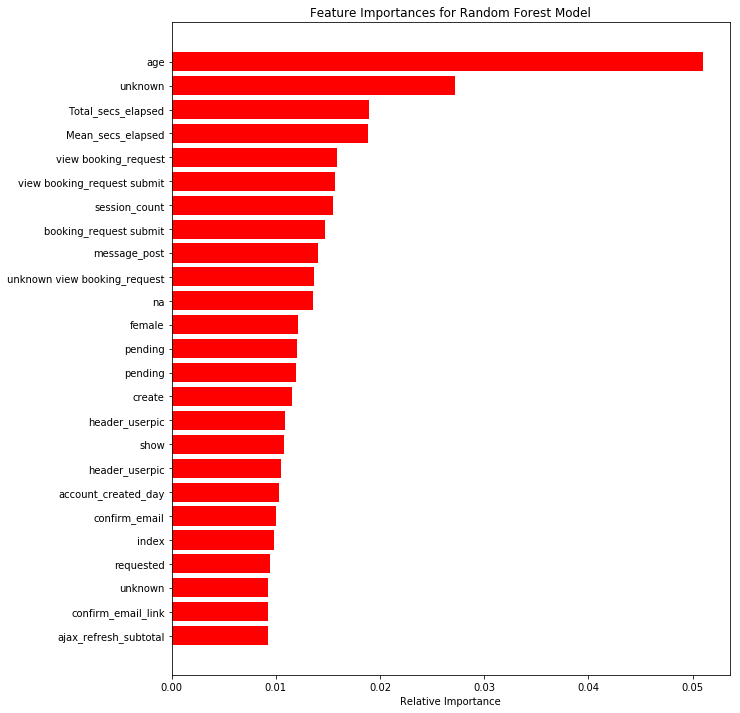

In [81]:
#https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

#Feature Importance for Random Forest Model

features = final_column_list
importances = clf_rf.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances for Random Forest Model')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We see the sessions features like 'total_seconds_elapsed', 'mean_seconds_elapsed', 'session_count' are very important features. From the train dataset features 'age' is most important. We have proccessed this feature well in our EDA part.

In [90]:
results_rf = clf_rf.cv_results_
print(results_rf)

{'mean_fit_time': array([ 517.69215679,  255.67794959, 1986.84434342, 1223.64657966,
       3383.19102017, 3009.25519983, 3598.19907228, 1032.34590475,
        439.8657163 , 1492.09750406]), 'std_fit_time': array([  1.69700284,  19.50375507,   5.46851993,  83.92335066,
       143.21310495,  29.45131101, 150.53647534,   6.39876851,
         0.62818523,   6.02152905]), 'mean_score_time': array([17.69679817, 16.98665404, 48.45418278, 20.13123043, 64.03119524,
       49.9464225 , 47.78500279, 20.72060823, 19.11369252, 33.71228385]), 'std_score_time': array([2.68499458, 4.49489062, 3.13584423, 1.80891055, 4.08456398,
       3.12398099, 1.99303807, 1.33114268, 1.50700287, 0.57473963]), 'param_n_estimators': masked_array(data=[100, 100, 1000, 200, 800, 800, 700, 200, 200, 700],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[5, 5, 2, 2, 5

In [91]:
X_axis = np.array(results_rf['param_n_estimators'].data, dtype=float)
Y_axis = np.array(results_rf['param_max_depth'].data, dtype=float)

##### HeatMap to show the Train and CV NDCG score for different values of 'max_depth' and 'n_estimators' :

Text(0.5,1,'Train NDCG HeatMap')

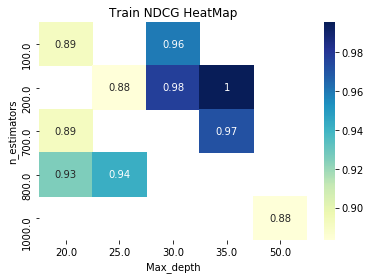

In [93]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results_rf),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('Train NDCG HeatMap')

Text(0.5,1,'CV NDCG HeatMap')

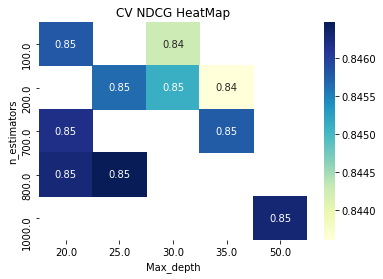

In [95]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results_rf),values='mean_test_score', index=X_axis, columns=Y_axis)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('CV NDCG HeatMap')

##### Fitting the best estimator as given by the randomsearch cv to the test data :

In [82]:
pred_Y_Test = clf_rf.predict_proba(X_Test_vec)

In [84]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

#Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test[i])[::-1][:5]).tolist()
    
#Creating the submission dataframe

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\rf_submission.csv', index = False)

In [23]:
#Saving the RF Model 1:
joblib.dump(clf_rf,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\clf_rf']

In [79]:
clf_rf = joblib.load(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf')

##### 2. Manually fitting the best hyper-parameter values as seen from the previous heatmap - Random Forest Model 2 :

From the previous train and cv ndcg heatmap we saw that for max_depth = 25 and n_estimators = 200, train ndcg score is 0.88 and cv_ndcg score is 0.85. This gap is less than what the best estimator of randomsearch cv has given. So, we are training a new model here with these hyper-parameter values.

In [96]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 25)
rf.fit(X_Train_vec,Y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [123]:
#Saving the RF Model 2:
joblib.dump(rf,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf_depthEstimator') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\clf_rf_depthEstimator']

In [124]:
rf = joblib.load(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf_depthEstimator')

In [97]:
pred_Y_Train_rf = rf.predict_proba(X_Train_vec)
pred_Y_Cv_rf = rf.predict_proba(X_Cv_vec)

In [98]:
train_ndcg_rfNew = ndcg_score(Y_Train, pred_Y_Train_rf, k=5)
print('Train : ',train_ndcg_rfNew)
cv_ndcg_rfNew = ndcg_score(Y_Cv, pred_Y_Cv_rf, k=5)
print('CV : ',cv_ndcg_rfNew)

Train :  0.9359856629365361
CV :  0.8465756014395978


In [99]:
pred_Y_Test_rf = rf.predict_proba(X_Test_vec)

In [100]:
ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test_rf[i])[::-1][:5]).tolist()
    
#Creating the submission dataframe

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\rf2_submission.csv', index = False)

##### 3. Using the best 80% features of the estimator given by previous randomsearch cv to train a new Random Forest Model 3 :

In [103]:
top_80 = int(len(clf_rf.best_estimator_.feature_importances_)*0.8)
importances = clf_rf.best_estimator_.feature_importances_
indices = (np.argsort(importances))[::-1][:top_80]

In [104]:
# https://stackoverflow.com/questions/48099075/how-to-get-columns-from-big-sparse-csc-matrix

#Creating the new train dataset with best features :
train_columns = []

for i in indices:
    
    train_columns.append(X_Train_vec[:,i])
    
X_Train_vec_new = hstack(train_columns)

#Creating the new test dataset with the best features :
test_columns = []

for i in indices:
    
    test_columns.append(X_Test_vec[:,i])
    
X_Test_vec_new = hstack(test_columns)

#Saving the new columns in a list :
final_column_list_new = []

for i in indices:
    
     final_column_list_new.append(final_column_list[i])

In [165]:
print("Final Data matrix with best 80% fetaures :")
print('X_Train : ',X_Train_vec_new.shape)
print('X_Test : ',X_Test_vec_new.shape)
print('Total number of columns (updated) : ',len(final_column_list_new))

Final Data matrix with best 80% fetaures :
X_Train :  (59052, 526)
X_Test :  (62096, 526)
Total number of columns (updated) :  526


Fitting the model :

In [ ]:
params = {
'n_estimators' : [100, 200, 300, 500, 700, 800, 1000],
'max_depth' : [15, 20, 25, 30, 35, 50],
'min_samples_split' : [2, 3, 5, 8],
'min_samples_leaf' : [1, 2, 5, 10] }

rf = RandomForestClassifier()

clf_rf = RandomizedSearchCV(rf, params, verbose=10,n_jobs=-1,scoring=ndcg_scorer)

In [106]:
clf_rf.fit(X_Train_vec_new,Y_Train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 129.5min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 196.9min remaining: 21.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 221.0min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 700, 800, 1000], 'max_depth': [15, 20, 25, 30, 35, 50], 'min_samples_split': [2, 3, 5, 8], 'min_samples_leaf': [1, 2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=10)

In [107]:
#Saving the RF Model 3:
joblib.dump(clf_rf,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf_feat') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\clf_rf_feat']

In [112]:
clf_rf.best_params_

{'n_estimators': 700,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 30}

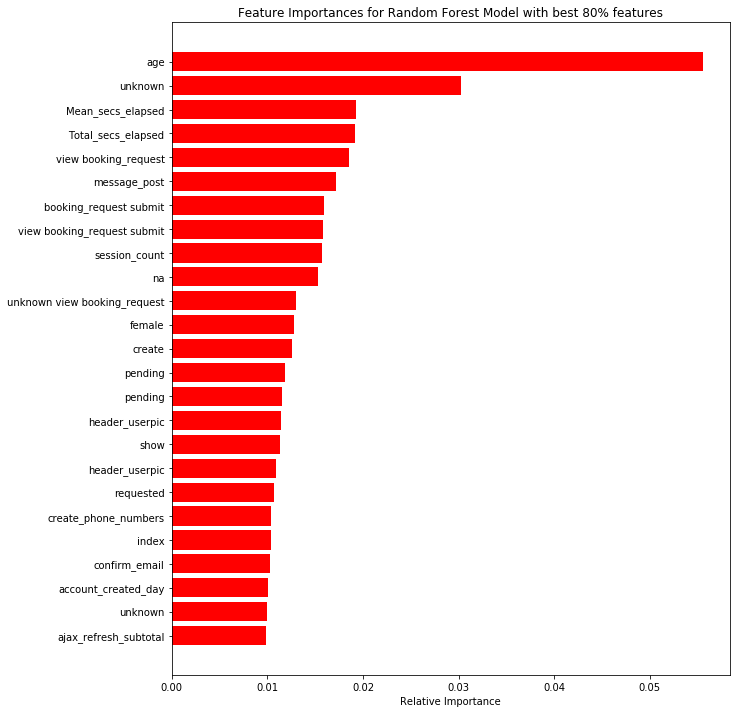

In [113]:
#Feature Importance for Random Forest Model

features = final_column_list_new
importances = clf_rf.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances for Random Forest Model with best 80% features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We see the sessions features like 'total_seconds_elapsed', 'mean_seconds_elapsed', 'session_count' are very important features. From the train dataset features 'age' is most important. We have proccessed this feature well in our EDA part.

In [114]:
results_rf = clf_rf.cv_results_
X_axis = np.array(results_rf['param_n_estimators'].data, dtype=float)
Y_axis = np.array(results_rf['param_max_depth'].data, dtype=float)

##### Heatmap for Train and CV NDCG Score :

Text(0.5,1,'Train NDCG HeatMap')

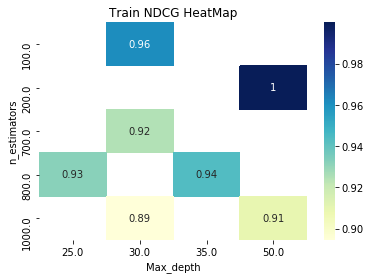

In [115]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results_rf),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('Train NDCG HeatMap')

Text(0.5,1,'CV NDCG HeatMap')

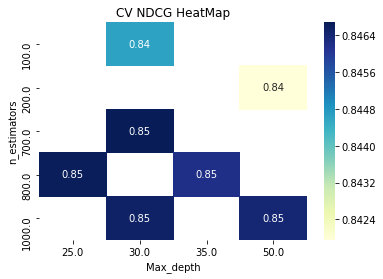

In [116]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results_rf),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('CV NDCG HeatMap')

##### Fitting the best estimator on the Test data :

In [109]:
pred_Y_Test_rf_feat = clf_rf.predict_proba(X_Test_vec_new)

In [110]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test_rf_feat[i])[::-1][:5]).tolist()
    
#Creating a new datadfrom for submission :

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\rf_feat_submission.csv', index = False)

##### 4. RF Model built on the full vectorized dataset with 5172 features :

###### Loading the full vectorized dataset :

In [ ]:
X_Train_fullVec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset_3\X_Train_vec.npz')
X_Cv_fullVec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset_3\X_Cv_vec.npz')
X_Test_fullVec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset_3\X_Test_vec.npz')

In [10]:
params = {
'n_estimators' : [100, 200, 300, 500, 700, 800],
'max_depth' : [5, 10, 15, 20, 25, 30, 35, 50],
'min_samples_split' : [2, 3, 5, 8],
'min_samples_leaf' : [1, 2, 5, 10] }

rf1 = RandomForestClassifier()

clf_rf1 = RandomizedSearchCV(rf1, params, verbose=10,n_jobs=-1,scoring=ndcg_scorer)

In [11]:
clf_rf1.fit(X_Train_fullVec,Y_Train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 81.6min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 103.6min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 105.7min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 500, 700, 800], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 50], 'min_samples_split': [2, 3, 5, 8], 'min_samples_leaf': [1, 2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=10)

In [12]:
clf_rf1.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 50}

In [13]:
pred_Y_Train_fullVec = clf_rf1.predict_proba(X_Train_fullVec)

In [14]:
#Train ndcg score

train_ndcg_rf1_fullVec = ndcg_score(Y_Train, pred_Y_Train_fullVec, k=5)
train_ndcg_rf1_fullVec

0.920382636291041

In [15]:
pred_Y_Cv_fullVec = clf_rf1.predict_proba(X_Cv_fullVec)

In [16]:
#CV ndcg score

cv_ndcg_rf1_fullVec = ndcg_score(Y_Cv, pred_Y_Cv_fullVec, k=5)
cv_ndcg_rf1_fullVec

0.84359449646054

In [17]:
#Saving the RF Model 4:
joblib.dump(clf_rf1,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf1') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\clf_rf1']

In [89]:
clf_rf1 = joblib.load(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf1')

In [202]:
X_Test_fullVec = sparse.load_npz(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset_3\X_Test_vec.npz')

In [203]:
with open(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\final_dataset_3\final_column_list.txt', 'rb') as fp:   # Unpickling
    final_column_list_fullVec = pickle.load(fp)
fp.close()

In [204]:
pred_Y_Test_fullVec = clf_rf1.predict_proba(X_Test_fullVec)

In [205]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test_fullVec[i])[::-1][:5]).tolist()
    
#Creating a new datadframe for submission :

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\rf_feat_fullVec_submission.csv', index = False)

##### 5. Retraining the best 80% feature dataset with new hyper-parameter values for Random Forest Model 5 :

In [125]:
params = {
'n_estimators' : [100, 200, 300, 500, 700, 800],
'max_depth' : [5, 10, 15, 20, 25, 30, 35, 50],
'min_samples_split' : [5,10,20,50,100],
'min_samples_leaf' : [5, 10, 15, 20] }

rf1 = RandomForestClassifier()
clf_rf_featHyp = RandomizedSearchCV(rf1, params, verbose=10,n_jobs=-1,scoring=ndcg_scorer)

In [126]:
clf_rf_featHyp.fit(X_Train_vec_new,Y_Train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 80.8min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 82.3min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 500, 700, 800], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 50], 'min_samples_split': [5, 10, 20, 50, 100], 'min_samples_leaf': [5, 10, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=10)

In [188]:
clf_rf_featHyp.best_params_

{'n_estimators': 800,
 'min_samples_split': 50,
 'min_samples_leaf': 5,
 'max_depth': 35}

In [128]:
#Saving the RF Model 5:
joblib.dump(clf_rf_featHyp,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_rf_featHyp') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\clf_rf_featHyp']

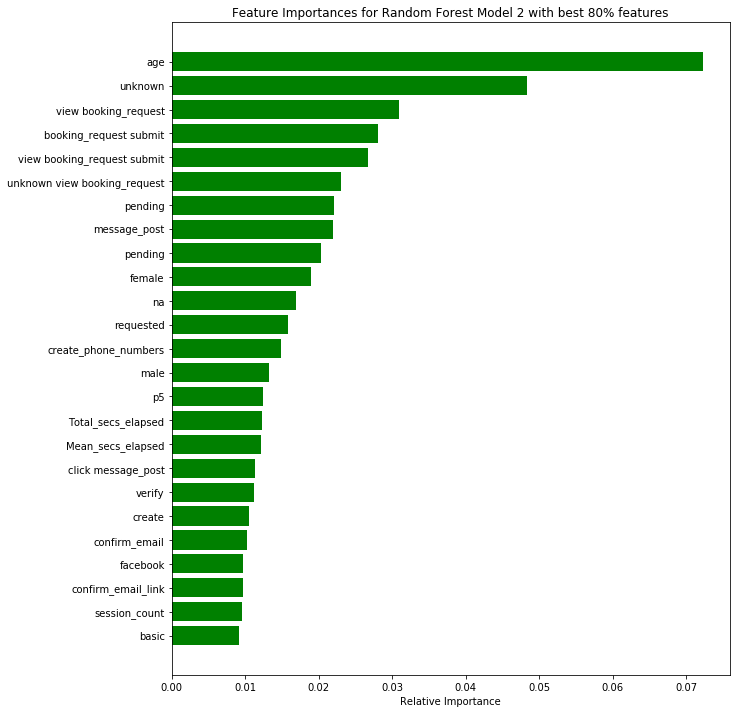

In [166]:
#Feature Importance for Random Forest Model

features = final_column_list_new
importances = clf_rf_featHyp.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances for Random Forest Model 2 with best 80% features')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

From the train dataset features 'age' is most important. We have proccessed this feature well in our EDA part.
But this feature importance shows some interesting changes. Features like 'view_booking_request', 'booking_request_submit', 'view_booking_request_submit' have a much higher importance in this model as compared to the other models. Whereas important features for other models like 'session_count', 'Total_secs_elapsed', 'Mean_secs_elapsed'  are very down in this list of important features. 

In [131]:
results_rf_featHyp = clf_rf_featHyp.cv_results_
X_axis = np.array(results_rf_featHyp['param_n_estimators'].data, dtype=float)
Y_axis = np.array(results_rf_featHyp['param_max_depth'].data, dtype=float)

##### HeatMap for Train and CV NDCG Score :

Text(0.5,1,'Train NDCG HeatMap')

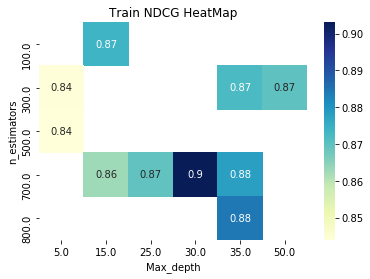

In [132]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results_rf_featHyp),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('Train NDCG HeatMap')

Text(0.5,1,'CV NDCG HeatMap')

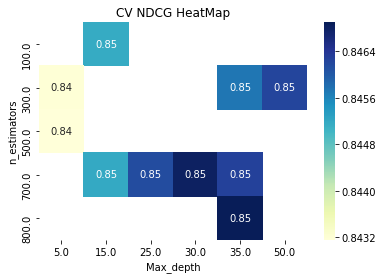

In [133]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results_rf_featHyp),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('CV NDCG HeatMap')

In [190]:
pred_Y_Test_rf_featHyp = clf_rf_featHyp.predict_proba(X_Test_vec_new)

In [191]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test_rf_featHyp[i])[::-1][:5]).tolist()
    
#Creating dataframe for submission:

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\rf_featHyp_submission.csv', index = False)

In [158]:
sub.head(6)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,IT
4,5uwns89zht,FR
5,jtl0dijy2j,NDF


Fitting the best estimator :

In [192]:
rf1_new = RandomForestClassifier(n_estimators=800, max_depth=35, min_samples_split=50, min_samples_leaf = 5)
rf1_new.fit(X_Train_vec_new,Y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [193]:
pred_Y_Test_rf_featHyp1 = rf1_new.predict_proba(X_Test_vec_new)

In [194]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test_rf_featHyp1[i])[::-1][:5]).tolist()
    
#Creating dataframe for submission:

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\rf_featHyp_submission2.csv', index = False)

#### 3. Xgboost :

In [ ]:
'''param_grid = {
'max_depth': [5, 10, 15, 20, 25, 30, 35, 50],
'learning_rate': [0.001, 0.01, 0.1, 0.2],
'n_estimators':[100, 200, 300, 500, 700, 800, 1000],
'colsample_bytree':[0.1,0.2,0.3,0.5,1],
'colsample_bylevel':[0.1,0.2,0.3,0.5,1]
}'''

In [32]:
param_grid = {
'max_depth': [5, 10, 15, 20, 25, 30, 35, 50],
'n_estimators':[100, 200, 300, 500, 700, 800]
}

xgb = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss')
clf_xgb = RandomizedSearchCV(xgb, param_grid,n_jobs=-1,verbose=2,scoring=ndcg_scorer, random_state=42)

In [33]:
clf_xgb.fit(X_Train_vec,Y_Train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 2224.6min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35, 50], 'n_estimators': [100, 200, 300, 500, 700, 800]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=2)

In [35]:
clf_xgb.best_params_

{'n_estimators': 700, 'max_depth': 5}

In [66]:
results = clf_xgb.cv_results_
print(results)

{'mean_fit_time': array([40840.553713  , 36463.77520148, 15405.23485955, 14976.49862234,
        7518.22309359, 16708.22038253,  6178.23316153, 10796.00919278,
       10838.37793239,  9186.97599014]), 'std_fit_time': array([ 172.95874688, 8871.011024  ,  896.90769901,  319.72680429,
         54.31914818,  318.07853499,  170.27001862,  279.17906382,
         12.02077067, 1345.87410942]), 'mean_score_time': array([171.80947272, 205.99530395, 134.93325758,  91.0164508 ,
        49.425946  , 106.7009031 ,  47.4094468 ,  60.89998341,
        84.29936846,  56.5339853 ]), 'std_score_time': array([ 8.31906892,  0.33255051, 36.82053024,  1.47463572,  1.86508673,
        1.48026337,  1.33582172,  2.17150141,  3.74813575,  9.06128102]), 'param_n_estimators': masked_array(data=[500, 700, 300, 200, 100, 200, 100, 200, 700, 200],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_max_de

In [67]:
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
Y_axis = np.array(results['param_max_depth'].data, dtype=float)

##### HeatMap for Train and CV NDCG Score for XGBoost Model :

Text(0.5,1,'Train NDCG HeatMap')

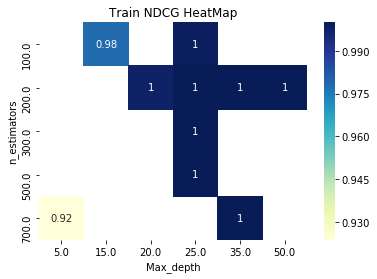

In [72]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('Train NDCG HeatMap')

Text(0.5,1,'CV AUC HeatMap')

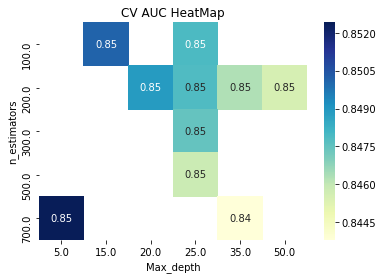

In [73]:
pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('CV AUC HeatMap')

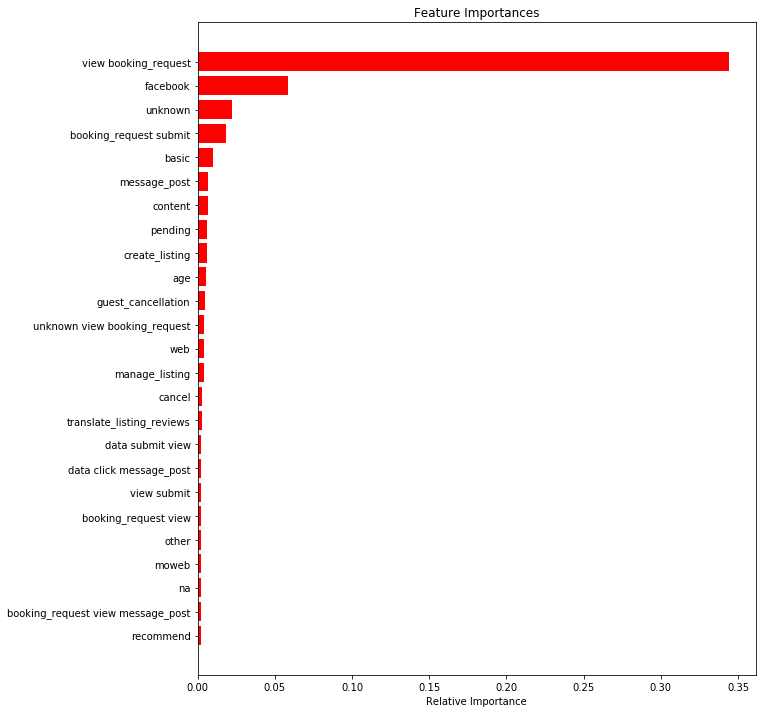

In [77]:
#feature importance

features = final_column_list
importances = clf_xgb.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We are not able to get any good inference from the this plot of feature importance.

In [36]:
pred_Y_Train = clf_xgb.predict_proba(X_Train_vec)

In [37]:
#Train ndcg score

train_ndcg_xgb = ndcg_score(Y_Train, pred_Y_Train, k=5)
train_ndcg_xgb

0.910366678884532

In [38]:
pred_Y_Cv = clf_xgb.predict_proba(X_Cv_vec)

In [39]:
#CV ndcg score

cv_ndcg_xgb = ndcg_score(Y_Cv, pred_Y_Cv, k=5)
cv_ndcg_xgb

0.8520178893365667

In [34]:
#Saving the XGBoost Model :
joblib.dump(clf_xgb,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_xgb') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\clf_xgb']

In [ ]:
clf_xgb = joblib.load(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\clf_xgb')

In [62]:
pred_Y_Test = clf_xgb.predict_proba(X_Test_vec)

In [65]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test[i])[::-1][:5]).tolist()
    
# Generate submission

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\xgb_submission.csv', index = False)

#### 4. Naive Bayes Model :

In [167]:
from sklearn.naive_bayes import MultinomialNB

In [173]:
params =  {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100]}

nb = clf = MultinomialNB()
clf_nb = RandomizedSearchCV(nb, params, verbose=10, n_iter=3 ,n_jobs=-1,scoring=ndcg_scorer)

In [174]:
clf_nb.fit(X_Train_vec,Y_Train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   29.7s remaining:   59.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   29.7s remaining:   37.2s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   53.4s remaining:   42.7s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   53.5s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   53.6s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          fit_params=None, iid='warn', n_iter=3, n_jobs=-1,
          param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=10)

In [175]:
clf_nb.best_estimator_

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [177]:
pred_Y_Train_nb = clf_nb.predict_proba(X_Train_vec)
pred_Y_CV_nb = clf_nb.predict_proba(X_Cv_vec)
pred_Y_Test_nb = clf_nb.predict_proba(X_Test_vec)

In [179]:
#NDCG Score:

train_ndcg_nb = ndcg_score(Y_Train, pred_Y_Train_nb, k=5)
print('Train NDCG for NB : ',train_ndcg_nb)
cv_ndcg_nb = ndcg_score(Y_Cv, pred_Y_CV_nb, k=5)
print('CV NDCG for NB : ',cv_ndcg_nb)

Train NDCG for NB :  0.5507672279091614
CV NDCG for NB :  0.546901162858761


In [180]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test_nb[i])[::-1][:5]).tolist()
    
# Generate submission

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\nb_submission.csv', index = False)

#### 5. Fitting LightGBM Model on best 80% features dataset:

In [181]:
import lightgbm as lgb

In [195]:
LGBM_clf = lgb.LGBMClassifier(random_state=0, n_jobs=-1, objective='multiclass')

#Hyperparameter Tuning
param_dict = {'max_depth': [5, 10, 15, 20, 25, 30], 'n_estimators' : [100, 200, 300, 500, 700, 800], 'num_leaves' : [20,30,40,50],'min_data_in_leaf' : [5, 10, 15, 20], 'learning_rate':[0.1, 0.01]}

LGBM_random_clf = RandomizedSearchCV(LGBM_clf, param_distributions=param_dict,
                                          n_iter=5,cv=3,scoring=ndcg_scorer,random_state=0, return_train_score=True)

LGBM_random_clf.fit(X_Train_vec_new, Y_Train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='multiclass',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'max_depth': [5, 10, 15, 20, 25, 30], 'n_estimators': [100, 200, 300, 500, 700, 800], 'num_leaves': [20, 30, 40, 50], 'min_data_in_leaf': [5, 10, 15, 20], 'learning_rate': [0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True,
          scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
          verbose=0)

In [196]:
joblib.dump(LGBM_random_clf,r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\models\LGBM_random_clf') 

['C:\\Users\\NamrataT\\Desktop\\CS_1\\Dataset\\airbnb-recruiting-new-user-bookings\\models\\LGBM_random_clf']

In [199]:
pred_Y_Train_lgbm = LGBM_random_clf.predict_proba(X_Train_vec_new)
#pred_Y_CV_lgbm = LGBM_random_clf.predict_proba(X_Cv_vec_new)

In [201]:
train_ndcg_lgbm = ndcg_score(Y_Train, pred_Y_Train_lgbm, k=5)
print('Train NDCG for LGBM : ',train_ndcg_lgbm)

Train NDCG for LGBM :  0.8766147650541029


In [197]:
pred_Y_Test_lgbm = LGBM_random_clf.predict_proba(X_Test_vec_new)

In [198]:
#https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred_Y_Test_lgbm[i])[::-1][:5]).tolist()
    
# Generate submission

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv(r'C:\Users\NamrataT\Desktop\CS_1\Dataset\airbnb-recruiting-new-user-bookings\submission\lgbm_submission.csv', index = False)

### SUMMARY :

In [1]:
# Importing Pretty Table
from prettytable import PrettyTable

In [13]:
x = PrettyTable()
x.field_names = ['Model', 'Train NDCG','Test NDCG (From Kaggle)']
x.add_row(['Logistic Regression','0.8164','0.83252'])
x.add_row(['Random Forest with 658 features','0.9359','0.87883'])
x.add_row(['Random Forest with 5172 features','0.9203','0.87658'])
x.add_row(['XGBoost','0.9103','0.76275'])
x.add_row(['Naive Bayes','0.5507','0.82241'])
x.add_row(['LIGHT GBM','0.8766','0.77386'])

print(x)

+----------------------------------+------------+-------------------------+
|              Model               | Train NDCG | Test NDCG (From Kaggle) |
+----------------------------------+------------+-------------------------+
|       Logistic Regression        |   0.8164   |         0.83252         |
| Random Forest with 658 features  |   0.9359   |         0.87883         |
| Random Forest with 5172 features |   0.9203   |         0.87658         |
|             XGBoost              |   0.9103   |         0.76275         |
|           Naive Bayes            |   0.5507   |         0.82241         |
|            LIGHT GBM             |   0.8766   |         0.77386         |
+----------------------------------+------------+-------------------------+


In this notebook we have applied different ML models on the dataset that we have proccessed earlier. We have fit Logistic Regression, Naive Bayes, Random Forest and GBDT Classifiers like XGBoost and LightGBM Classifiers. The best test result came from Random Forest model. The worst result came from XGBoost model, surprisingly. We have tuned the hyper-parameters for all the models and have plotted the heatmap to see how the tuning has worked. We have also plotted the feature importances for RF and XGBoost models.

The best score came as 0.87838.